<a href="https://colab.research.google.com/github/JyothikaKanchu/JyothikaKanchu-benignclassification/blob/main/benignclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pathlib import Path

import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from matplotlib.image import imread

import tensorflow as tf
#from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import glob
import PIL
import random

random.seed(100)


Num GPUs Available:  1


In [ ]:
# Define path to benign images only
benign_path = '/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign'

# Recursively gather image file paths
benign_images = glob.glob(os.path.join(benign_path, '**', '*.png'), recursive=True)

print(f"Total benign images found: {len(benign_images)}")

Total malignant images found: 2480


In [ ]:
benign_path = '/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign'
breast_img_paths = glob.glob(os.path.join(benign_path, '**', '*.png'), recursive=True)

for img_path in breast_img_paths[:5]:
    print(img_path)


/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-012.png
/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-017.png
/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-021.png
/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-025.png
/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-007.png


In [ ]:

A, F, PT, TA = [], [], [], [] # subtypes for benign

for img in breast_img_paths:
    img_name = Path(img).name
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P'and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)

benign= A + F + PT + TA

In [ ]:
print("Total benign examples:", len(benign))
print("Subtype counts:")
print(f"DC: {len(A)} | LC: {len(F)} | MC: {len(PT)} | PC: {len(TA)}")

Total benign examples: 2480
Subtype counts:
DC: 444 | LC: 1014 | MC: 453 | PC: 569


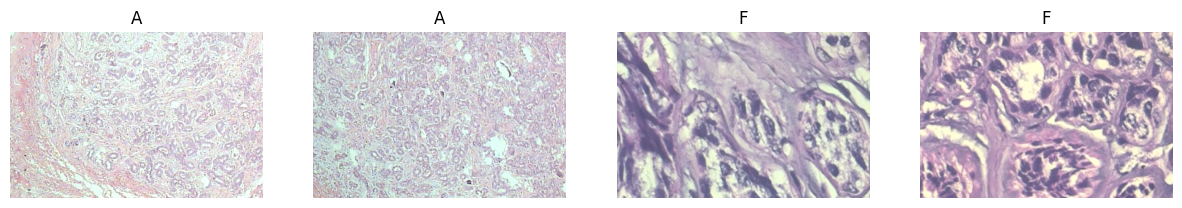

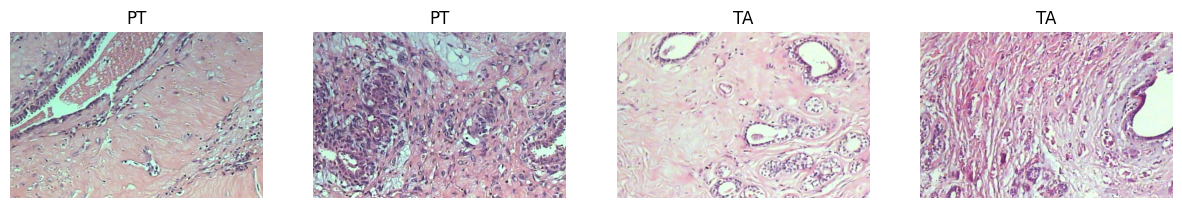

In [ ]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)
        ax.axis('off')

    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()

display_images("A", "F",A, F)
display_images("PT", "TA", PT, TA)


In [ ]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    with tf.device('/GPU:0'):  # Ensure TensorFlow image ops run on GPU
        for img in img_list:
            image = cv2.imread(img, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0

            # Apply augmentations (will return 3 images per input)
            augmented_images = augment_image(image)

            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
    return img_array

def augment_image(img):
    augmented_images = [img]
    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)
    return augmented_images

# Load benign subtypes with GPU acceleration
A_imgs = load_and_resize_images(A, 0)
print("1")

F_imgs = load_and_resize_images(F, 1)
print("2")
PT_imgs = load_and_resize_images(PT, 2)
print("3")
TA_imgs = load_and_resize_images(TA, 3)


1
2
3


In [ ]:
data_m = A_imgs + F_imgs + PT_imgs + TA_imgs
print("Total number of benign examples:", len(data_m))

random.shuffle(data_m)

# Split into train, validation, test
dataTrain_m, dataTest_m = train_test_split(data_m, test_size=0.2, random_state=42)
dataTrain_m, dataVal_m = train_test_split(dataTrain_m, test_size=0.25, random_state=42)  # 60/20/20 split

# Adjust labels to be 0-3 for categorical classification
dataTrain_m = [(image, label) for image, label in dataTrain_m]
dataVal_m = [(image, label) for image, label in dataVal_m]
dataTest_m = [(image, label) for image, label in dataTest_m]


Total number of benign examples: 7440


In [ ]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)
    labels = np.array(labels)
    labels = tf.keras.utils.to_categorical(labels, num_classes=4)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset_m = create_tf_dataset(dataTrain_m)
val_dataset_m = create_tf_dataset(dataVal_m)
test_dataset_m = create_tf_dataset(dataTest_m)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


base_model_m = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Extract intermediate layers
layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
intermediate_outputs = [base_model_m.get_layer(name).output for name in layer_names]
intermediate_model = Model(inputs=base_model_m.input, outputs=intermediate_outputs)

# Define intermediate branches
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

fusion = tf.keras.layers.Concatenate()(branch_outputs)

# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)

benign_model = Model(inputs=base_model_m.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)
benign_model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import time

start_time = time.time()

history_m = benign_model.fit(
    train_dataset_m,
    validation_data=val_dataset_m,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
print(f"Total time taken to train the model: {end_time - start_time:.2f} seconds")


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.4419 - loss: 1.8469 - val_accuracy: 0.1821 - val_loss: 1.7669 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.6633 - loss: 1.1685 - val_accuracy: 0.1821 - val_loss: 1.8142 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.7754 - loss: 0.9482 - val_accuracy: 0.1821 - val_loss: 1.7885 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.8623 - loss: 0.7772 - val_accuracy: 0.1841 - val_loss: 1.7049 - learning_rate: 1.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.8927 - loss: 0.6981 - val_accuracy: 0.3978 - val_loss: 1.4694 - learning_rate: 1.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.9441 - loss: 0.5923 - val_accuracy: 0.6647 - val_loss: 1.1758 - learning_rate: 1.0000e-04
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accur

In [ ]:
test_loss, test_acc = benign_model.evaluate(test_dataset_m)
print(f"Test accuracy benign subtype classification): {test_acc:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9640 - loss: 0.3578
Test accuracy benign subtype classification): 0.9617


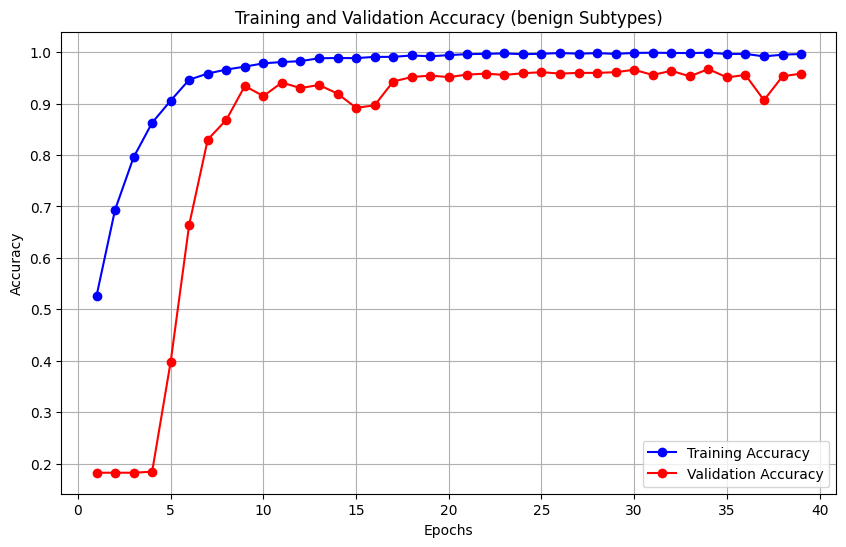

In [ ]:
import matplotlib.pyplot as plt

train_acc = history_m.history['accuracy']
val_acc = history_m.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (benign Subtypes)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

y_true_m = []
y_pred_m = []

for images, labels in test_dataset_m:
    predictions_m = benign_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions_m, axis=1)
    true_classes = np.argmax(labels, axis=1)

    y_true_m.extend(true_classes)
    y_pred_m.extend(predicted_classes)

# Convert to numpy arrays
y_true_m = np.array(y_true_m)
y_pred_m = np.array(y_pred_m)

print("Classification Report:")
print(classification_report(y_true_m, y_pred_m, target_names=["AD", "FD", "PT", "TA"]))

# Macro-averaged scores
precision = precision_score(y_true_m, y_pred_m, average='macro')
recall = recall_score(y_true_m, y_pred_m, average='macro')
f1 = f1_score(y_true_m, y_pred_m, average='macro')

print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

          AD       0.98      0.97      0.98       256
          FD       0.97      0.96      0.96       667
          PT       0.92      0.92      0.92       231
          TA       0.96      0.99      0.97       334

    accuracy                           0.96      1488
   macro avg       0.96      0.96      0.96      1488
weighted avg       0.96      0.96      0.96      1488

Macro Precision: 0.9581
Macro Recall:    0.9602
Macro F1 Score:  0.9591


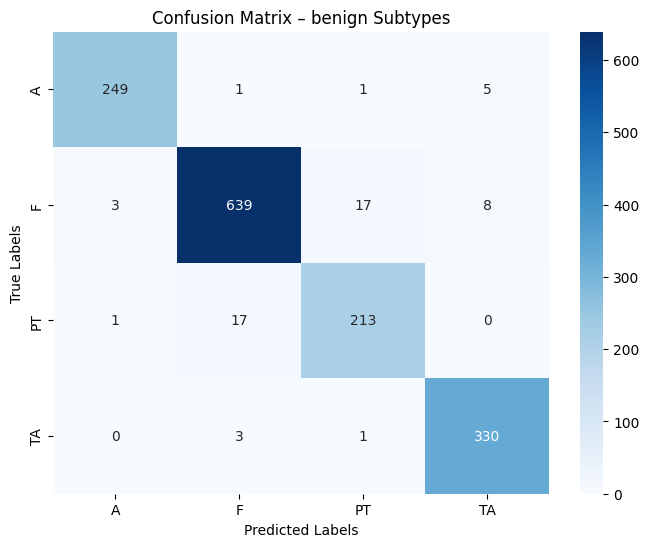

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_m = confusion_matrix(y_true_m, y_pred_m)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_m, annot=True, fmt='d', cmap='Blues',
            xticklabels=["A", "F", "PT", "TA"],
            yticklabels=["A", "F", "PT", "TA"])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix – benign Subtypes')
plt.show()


In [ ]:
benign_model.save('benign_model.h5')

In [ ]:
from google.colab import files
files.download('benign_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>